In [78]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
import os
import pandas as pd
import math
from numpy import mean,std
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.models import load_model,Sequential
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold,StratifiedShuffleSplit, train_test_split
from tensorflow.keras.utils import to_categorical

# *** Upload Dataset ***

In [80]:
folder_lists = []
text_files_lists = []
files_paths = []
labels = []
dataset = np.array([])
data = []
frame_count=30

In [81]:
def load_txt_file(_path):
  data = np.loadtxt(_path)
  return data

In [82]:
def get_txt_files_names(folder_path):
  text_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith('.txt')]
  text_files.sort()
  return text_files

In [83]:
def get_folder_names(path):
    folders = []
    for f in os.listdir(path):
        if os.path.isdir(os.path.join(path, f)):
            folders.append(f)
    folders.sort()
    return folders[0:]

load files pathes and get labels

In [84]:
# Example usage:
_path = r"/content/drive/MyDrive/bitirmeProjesi/dataset"
root=r"/content/drive/MyDrive/bitirmeProjesiGuncel/"
folders = get_folder_names(_path)
for folder in folders:
    print(folder)
    folder_path = os.path.join(_path, folder)
    text_files = get_txt_files_names(folder_path)   #belirtilen klasördeki dosyaları almak için
    for text_file in text_files:
        file_path = os.path.join(folder_path, text_file)  #dosya olup olmadığı kontrol edilir
        files_paths.append(file_path)   #dosyalar files_paths eklenir
        labels.append(folder)  #labels listesine de klasörler eklenir
#buradafolder listesine aynıklasör adı içinde kac tane dosya varsa o kadar yazılır


#for i in range(len(files_paths)):
  #print(f"filename: {files_paths[i]} label: {labels[i]}")

print(len(labels))
print(len(files_paths))


aparkat
direkt yumruk
kroşe
servis(voleybol)
tekme
310
310


padding to fixed timestep

In [85]:
def padding(actions, max_length):
    padded_data = []
    for action in actions:
        if action.shape[0] < max_length:
            repetitions = max_length // action.shape[0]
            remainder = max_length % action.shape[0]
            if remainder>0:
              total_addition = repetitions + 1
            else:
              total_addition = repetitions
            padded_sequence = np.tile(action, (total_addition, 1))[:max_length, :]
            padded_data.append(padded_sequence)
        else:
            padded_data.append(action[:max_length, :])
    return padded_data

load videos data and padding it

In [86]:
for file_path in files_paths:
    txt_array = load_txt_file(file_path)
    data.append(txt_array)
padded_data = padding(data,frame_count)
arr = np.array(padded_data)
arr= arr[:, :, 1:]
arr.shape

(310, 30, 75)

In [87]:
reshaped_data=arr.reshape(arr.shape[0], frame_count, 25, 3)

# *** Extracte Features to feed the model from the crude datas ( pose estimation) ***

In [88]:
#iki nokta(joint) arasındaki uzaklığın hesaplanması
def calculate_distance(coord1, coord2):
    return np.linalg.norm(coord1 - coord2)

#üç nokta(joint) arasındaki açının hesaplanması
def calculate_angle(coord1, coord2, coord3):
    vec1 = coord1 - coord2
    vec2 = coord3 - coord2
    cos_theta = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))
    return np.degrees(angle)

In [89]:
# Eklem noktaları için indeksler
hand_indices = [7, 11]
elbow_indices = [5, 9]
shoulder_indices = [4, 8]
hip_indices = [12, 16]
knee_indices = [13, 17]
ankle_indices = [14, 18]
wrist_indices = [6, 10]
#------------------two sides-------------------
dist_joint_triples = [(6, 10),(13, 17)]
angle_features=[]
distance_features=[]
for sample_idx in range(reshaped_data.shape[0]):
    sample_features_angles = []
    sample_features_distances = []
    for time_step_idx in range(reshaped_data.shape[1]):
        frame_features_angles = []
        frame_features_distances= []

        # distance between the right and left ankle
        # distance between right and left wrists
        for triple in dist_joint_triples:
          joint1 = reshaped_data[sample_idx, time_step_idx, triple[0]]
          joint2 = reshaped_data[sample_idx, time_step_idx, triple[1]]
          # mesafeyi hesapla
          frame_features_distances.append(calculate_distance(joint1, joint2))
        #-----------------------------------------------------------------------------
        for i in range(2):  # 0: sol, 1: sağ
            hand = reshaped_data[sample_idx, time_step_idx, hand_indices[i]]
            elbow = reshaped_data[sample_idx, time_step_idx, elbow_indices[i]]
            wrist = reshaped_data[sample_idx, time_step_idx, wrist_indices[i]]
            shoulder = reshaped_data[sample_idx, time_step_idx, shoulder_indices[i]]
            hip = reshaped_data[sample_idx, time_step_idx, hip_indices[i]]
            knee = reshaped_data[sample_idx, time_step_idx, knee_indices[i]]
            ankle = reshaped_data[sample_idx, time_step_idx, ankle_indices[i]]
            spine_base = reshaped_data[sample_idx, time_step_idx, 0]
            neck = reshaped_data[sample_idx,time_step_idx,2]

            #12 tane mesafe
            #dis between wrist and hip
            frame_features_distances.append(calculate_distance(wrist,hip))
            #dis between wrist and shoulder
            frame_features_distances.append(calculate_distance(wrist,shoulder))
            #dis between elbow and neck
            frame_features_distances.append(calculate_distance(elbow , neck))
            # dis between hip and wrist
            frame_features_distances.append(calculate_distance(hip,wrist))
            #dis between spine base and wrist
            frame_features_distances.append(calculate_distance(spine_base,wrist))
            #distance between anckle and hip
            frame_features_distances.append(calculate_distance(hip,ankle))

            #14 tane angle
            #angle between wrist,elbow, shoulder
            frame_features_angles.append(calculate_angle(shoulder, elbow, wrist))
            #angle between hip shoulder elbow
            frame_features_angles.append(calculate_angle(hip,shoulder,elbow))
            #angle between hip, shoulder wrist
            frame_features_angles.append(calculate_angle(hip,shoulder,wrist))
            #angle between spin base,elbow,wrist
            frame_features_angles.append(calculate_angle(spine_base,elbow,wrist))
            #angle between ankle , knee,hip
            frame_features_angles.append(calculate_angle(hip,knee,ankle))
            #angle between knee, spine base , neck
            frame_features_angles.append(calculate_angle(knee,spine_base,neck))
            #angle between spine base , hip , ankle
            frame_features_angles.append(calculate_angle(spine_base,hip,ankle))


        sample_features_angles.append(frame_features_angles)
        sample_features_distances.append(frame_features_distances)

    angle_features.append(sample_features_angles)
    distance_features.append(sample_features_distances)
    angle_features_array= np.array(angle_features)
    distance_features_array=np.array(distance_features)

distance_array_length= distance_features_array.shape[2]
print(distance_features_array.shape)
print(angle_features_array.shape)


(310, 30, 14)
(310, 30, 14)


scaling only the distance datas using the standard scaling approach

In [90]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
distance_features_array = distance_features_array.reshape(-1, distance_array_length)
distance_scaler = StandardScaler()
scaled_distances = distance_scaler.fit_transform(distance_features_array)
scaled_distances= scaled_distances.reshape(310, frame_count, distance_array_length)
scaled_distances.shape

(310, 30, 14)

In [91]:
last_data = np.concatenate((scaled_distances ,angle_features_array), axis=2)
print("the shape of the datas : ",last_data.shape)

np.save("last_data",last_data)
labels_array= np.array(labels)
np.save("labels_array",labels_array)



the shape of the datas :  (310, 30, 28)


In [92]:
last_data = np.load("last_data.npy")
labels_array = np.load("labels_array.npy")
labels= labels_array.tolist()


In [93]:
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(labels)
batch_size_=16

# ***Build  Model***

In [94]:
#---------------------two conv1d layers
def build_model (trainX,trainy,valX,valy,ctr,root,opt="adam",activation_funtion_="relu",verbose=1):
  epochs, batch_size = 100, batch_size_
  n_timesteps, n_features = trainX.shape[1], trainX.shape[2]
  n_outputs = trainy.shape[1]  # Number of output units equals the number of classes
  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=3, activation=activation_funtion_, input_shape=(n_timesteps, n_features)))
  model.add(Conv1D(filters=64, kernel_size=3, activation=activation_funtion_))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.4))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(100, activation=activation_funtion_))
  model.add(Dense(n_outputs, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  checkpointer = ModelCheckpoint(filepath=root +f'face_model_{ctr}.h5', verbose=0, save_best_only=True)
  # Fit model
  history=model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose,callbacks=[checkpointer],validation_data=(valX, valy))

  return history

# ***Split the dataset into train, validation and test datasets***

In [95]:
xtrain_folds =[]
ytrain_folds=[]
xval_folds=[]
yval_folds=[]
models_paths =[]
histories =[]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, train_size=0.8, random_state=42)

# Generate the train/test indices
for train_index, test_index in sss.split(last_data, integer_labels):
    trainX, X_test = last_data[train_index], last_data[test_index]
    trainy, y_test = integer_labels[train_index], integer_labels[test_index]

y_test= to_categorical(y_test)
print("x test",X_test.shape)
print("y_test",y_test.shape)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
ctr =0
for train_index, test_index in skf.split(trainX, trainy):
  X_train, valX = trainX[train_index], trainX[test_index]
  y_train, valy = trainy[train_index], trainy[test_index]
  xtrain_folds.append(X_train)
  ytrain_folds.append(y_train)

  xval_folds.append(valX)
  yval_folds.append(valy)

  #to categorical
  y_train = to_categorical(y_train)
  valy = to_categorical(valy)

  history= build_model(X_train, y_train,valX,valy,ctr,root=root)
  histories.append(history)
  ctr +=1

# H5 dosya yollarını toplama
h5_file_paths = [os.path.join(root, f) for f in os.listdir(root) if f.endswith('.h5')]
h5_file_paths.sort()  # Dosya yollarını sıralama
models_paths=h5_file_paths

x test (62, 30, 28)
y_test (62, 5)
Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 30.2794 - accuracy: 0.2222

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 7s 151ms/step - loss: 30.2794 - accuracy: 0.2222 - val_loss: 12.8033 - val_accuracy: 0.3200
Epoch 2/100
13/13 [==============================] - 0s 32ms/step - loss: 12.5920 - accuracy: 0.3535 - val_loss: 4.1169 - val_accuracy: 0.4200
Epoch 3/100
13/13 [==============================] - 0s 33ms/step - loss: 6.7172 - accuracy: 0.3434 - val_loss: 2.9700 - val_accuracy: 0.4400
Epoch 4/100
13/13 [==============================] - 0s 34ms/step - loss: 3.3691 - accuracy: 0.4293 - val_loss: 1.5829 - val_accuracy: 0.5800
Epoch 5/100
13/13 [==============================] - 0s 34ms/step - loss: 2.8843 - accuracy: 0.4949 - val_loss: 1.4775 - val_accuracy: 0.5400
Epoch 6/100
13/13 [==============================] - 0s 25ms/step - loss: 2.0038 - accuracy: 0.5152 - val_loss: 0.9995 - val_accuracy: 0.6800
Epoch 7/100
13/13 [==============================] - 0s 11ms/step - loss: 1.7118 - accuracy: 0.5354 - val_loss: 1.1418 - val_accuracy: 0.6200
Epoch 8/100
13

Fold 1 - Training Accuracy: 0.9949495196342468, Validation Accuracy: 0.8799999952316284
Fold 2 - Training Accuracy: 0.9898989796638489, Validation Accuracy: 0.8600000143051147
Fold 3 - Training Accuracy: 0.9898989796638489, Validation Accuracy: 0.8600000143051147
Fold 4 - Training Accuracy: 0.979899525642395, Validation Accuracy: 0.8775510191917419
Fold 5 - Training Accuracy: 0.9949748516082764, Validation Accuracy: 0.795918345451355
Best Model is from Fold 1


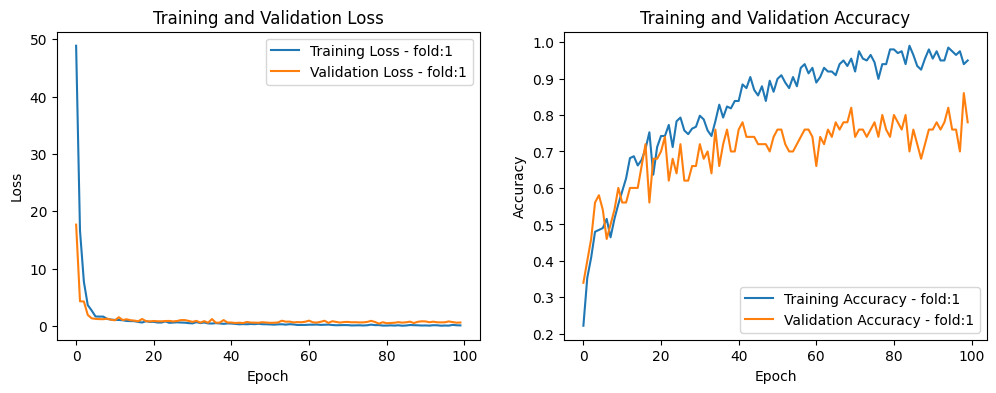

In [96]:
#------------------------------------Eğitim ve Doğrulama sonuçlarını yazdırma-------------------------------------
for i, history in enumerate(histories):
    print(f"Fold {i+1} - Training Accuracy: {max(history.history['accuracy'])}, Validation Accuracy: {max(history.history['val_accuracy'])}")

# En iyi modeli belirleme
best_fold = np.argmax([max(history.history['val_accuracy']) for history in histories]) + 1
print(f"Best Model is from Fold {best_fold}")


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(histories[best_fold].history['loss'], label=f'Training Loss - fold:{best_fold}')
plt.plot(histories[best_fold].history['val_loss'], label=f'Validation Loss - fold:{best_fold}')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(histories[best_fold].history['accuracy'], label=f'Training Accuracy - fold:{best_fold}')
plt.plot(histories[best_fold].history['val_accuracy'], label=f'Validation Accuracy - fold:{best_fold}')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

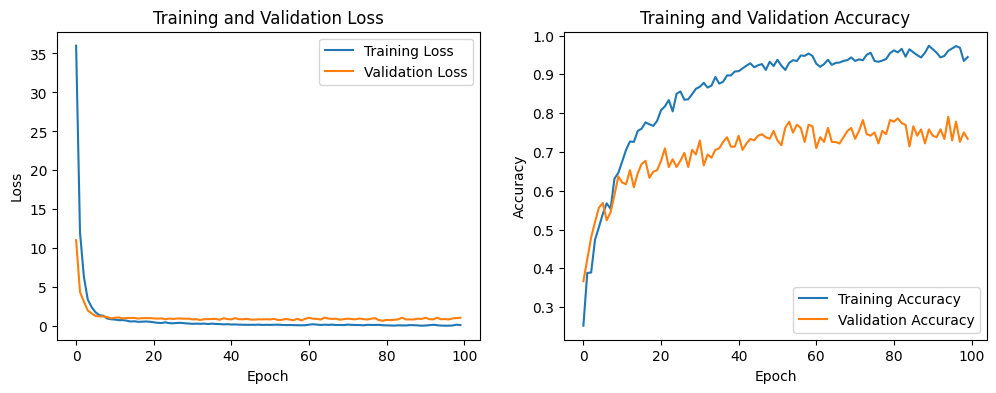

In [97]:

#-------------------------------- Initialize lists to store summed values of each metric across folds------------------------------------------------------

losses = []
val_losses = []
accuracies = []
val_accuracies = []


# Assume histories is a list of Keras History objects
# Her epoch için kayıpları ve doğrulukları toplama
for history in histories:
    losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])
    accuracies.append(history.history['accuracy'])
    val_accuracies.append(history.history['val_accuracy'])

# Transpose the lists to get lists of losses, val_losses, etc., for each epoch
# Listelerin transpozunu alarak her epoch için kayıpları ve doğrulukları elde etme

losses = list(zip(*losses))
val_losses = list(zip(*val_losses))
accuracies = list(zip(*accuracies))
val_accuracies = list(zip(*val_accuracies))

# Calculate average metrics across all folds for each epoch
# Her epoch için ortalama metrikleri hesaplama
avg_loss = [sum(_losses) / len(_losses) for _losses in losses]
avg_val_loss = [sum(_val_losses) / len(_val_losses) for _val_losses in val_losses]
avg_accuracy = [sum(_accuracies) / len(_accuracies) for _accuracies in accuracies]
avg_val_accuracy = [sum(_val_accuracies) / len(_val_accuracies) for _val_accuracies in val_accuracies]

#-----------------------------the mean of the five models graph-------------------------------------------------------------

# Plotting the training and validation loss
# Eğitim ve doğrulama kayıplarını çizme
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(avg_loss, label='Training Loss')
plt.plot(avg_val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(avg_accuracy, label='Training Accuracy')
plt.plot(avg_val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 28, 64)            5440      
                                                                 
 conv1d_3 (Conv1D)           (None, 26, 64)            12352     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 13, 64)            0         
 g1D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 13, 64)            0         
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 6, 64)             0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 384)              

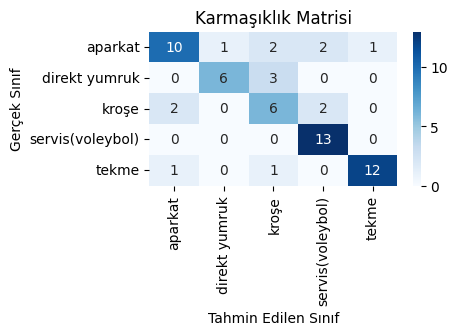

In [98]:

#----------------------------------------------------best modeli test etmek ----------------------------------------------------------------------------
best_model_path = root + f'face_model_{best_fold}.h5'
best_model = load_model(best_model_path)

print(best_model.summary())

from sklearn import metrics
# Son fold'un test verilerini kullanarak değerlendirme
_, accuracy = best_model.evaluate(X_test, y_test, batch_size=15, verbose=1)
print(f"Test Accuracy: {accuracy}")

y_pred = best_model.predict(X_test)
y_pred_single = np.argmax(y_pred, axis=1).tolist()
testy_single = np.argmax(y_test, axis=1).tolist()

#--------------------------------------------confusion matrix ----------------------------------

cm = confusion_matrix(testy_single, y_pred_single)
# Karmaşıklık matrisini görselleştirme
plt.figure(figsize=(4,2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=folders, yticklabels=folders)
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.title('Karmaşıklık Matrisi')
plt.show()



In [99]:
#-----------------------------------------------calssification report ------------------------------------------------------------------------------
from sklearn import metrics
# Classification report
classification_report = metrics.classification_report(testy_single, y_pred_single, digits=4, output_dict=True)
df_classification_report = pd.DataFrame(classification_report).transpose()
#print(df_classification_report)
# Görselleştirme için gerekli veriler
metrics = ['precision', 'recall', 'f1-score']
df_metrics = df_classification_report[metrics].iloc[:-3, :]
df_metrics


,precision,recall,f1-score
0,0.769231,0.625000,0.689655
1,0.857143,0.666667,0.750000
2,0.500000,0.600000,0.545455
3,0.764706,1.000000,0.866667
4,0.923077,0.857143,0.888889


In [100]:
b_xtrain = xtrain_folds[best_fold]
b_ytrain= ytrain_folds[best_fold]
b_xval=xval_folds[best_fold]
b_yval= yval_folds[best_fold]


b_ytrain = to_categorical(b_ytrain)
b_yval = to_categorical(b_yval)



print(b_xtrain.shape)
print(X_test.shape)
print(b_xval.shape)

import statistics
def get_result (b_xtrain,b_ytrain,X_test,b_ytest,b_xval,b_yval,ctr,opt,activation_funtion_,root_,accuracies_,accuracies_val_,test_accuracies_):
  history = build_model(b_xtrain,b_ytrain,b_xval,b_yval,ctr,root_,opt,activation_funtion_,0)
  accuracies_.append(statistics.mean(history.history['accuracy']))
  accuracies_val_.append(statistics.mean(history.history['val_accuracy']))
  model = load_model(root_ +f'face_model_{ctr}.h5')
  from sklearn import metrics
  _, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size_, verbose=1)
  test_accuracies_.append(accuracy)

  print(f" Test Accuracy of the face_model_{ctr}: {accuracy}")


(198, 30, 28)
(62, 30, 28)
(50, 30, 28)


In [101]:
activation_functions = ['relu', 'tanh', 'elu']
optimizers = ['adam', 'adamax']
root_ = "/content/drive/MyDrive/models/cnn_models/"
ctr = 0
accuracies_=[]
accuracies_val_=[]
test_accuracies_ =[]
model_names =[]

# Eğitim ve değerlendirme döngüsü
for activation_function in activation_functions:
    for optimizer__ in optimizers:
      if optimizer__ =='adam' and activation_function =='relu':
        continue
      else :
        get_result(b_xtrain, b_ytrain, X_test, y_test, b_xval, b_yval, ctr, optimizer__, activation_function, root_,accuracies_,accuracies_val_,test_accuracies_)
        model_names.append(f"{activation_function} - {optimizer__}")

        ctr += 1


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 1s 62ms/step - loss: 0.8664 - accuracy: 0.7258
 Test Accuracy of the face_model_0: 0.725806474685669
4/4 [==============================] - 0s 6ms/step - loss: 0.6352 - accuracy: 0.7903
 Test Accuracy of the face_model_1: 0.7903226017951965
4/4 [==============================] - 0s 4ms/step - loss: 0.7079 - accuracy: 0.6935
 Test Accuracy of the face_model_2: 0.6935483813285828
4/4 [==============================] - 0s 4ms/step - loss: 0.6735 - accuracy: 0.7581
 Test Accuracy of the face_model_3: 0.7580645084381104
4/4 [==============================] - 0s 4ms/step - loss: 0.7641 - accuracy: 0.7742
 Test Accuracy of the face_model_4: 0.774193525314331


In [102]:
model_names.append("relu - adam")
accuracies_.append(statistics.mean(histories[best_fold].history['accuracy']))
accuracies_val_.append(statistics.mean(histories[best_fold].history['val_accuracy']))
test_accuracies_.append(accuracy)

In [103]:
combined_list = [[accuracies_[i], accuracies_val_[i], test_accuracies_[i]] for i in range(len(accuracies_))]
df = pd.DataFrame(combined_list, columns=["accuracy", "validation accuracy", "test accuracy"],index=model_names)
df

,accuracy,validation accuracy,test accuracy
relu - adamax,0.746768,0.6136,0.725806
tanh - adam,0.831667,0.6856,0.790323
tanh - adamax,0.914697,0.7212,0.693548
elu - adam,0.876313,0.7298,0.758065
elu - adamax,0.817222,0.6692,0.774194
relu - adam,0.824747,0.6998,0.758065


### **get the classification report of model in three situation**

In [104]:
from sklearn import metrics
test_accuracies_for_difflayers = []
def build_model2 (trainX,trainy,valX,valy,ctr,root,opt="adam",activation_funtion_="relu",verbose=1):
  epochs, batch_size = 100, batch_size_
  n_timesteps, n_features = trainX.shape[1], trainX.shape[2]
  n_outputs = trainy.shape[1]  # Number of output units equals the number of classes
  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=3, activation=activation_funtion_, input_shape=(n_timesteps, n_features)))
  model.add(Conv1D(filters=64, kernel_size=3, activation=activation_funtion_))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.4))
  model.add(Conv1D(filters=128, kernel_size=3, activation=activation_funtion_))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(100, activation=activation_funtion_))
  model.add(Dense(n_outputs, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  checkpointer = ModelCheckpoint(filepath=root +f'face_model_{ctr}.h5', verbose=0, save_best_only=True)
  # Fit model
  history=model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose,callbacks=[checkpointer],validation_data=(valX, valy))

  return history



build_model2(b_xtrain,b_ytrain,b_xval,b_yval,1,"/content/drive/MyDrive/models/cnn_models/layers/")
#------------------------load the model
loading_model2 = load_model(root_ +f'cnn_layers2.h5')
_,test_ac2 =loading_model2.evaluate (X_test, y_test)
test_accuracies_for_difflayers.append(test_ac2)

# Classification report

y_pred2 = loading_model2.predict(X_test)
y_pred_single2 = np.argmax(y_pred2, axis=1).tolist()
testy_single2 = np.argmax(y_test, axis=1).tolist()

ct2= metrics.classification_report(testy_single2, y_pred_single2, digits=4, output_dict=True)
df_classification_report2 = pd.DataFrame(ct2).transpose()
metrics2 = ['precision', 'recall', 'f1-score']
df_metrics2 = df_classification_report2[metrics2].iloc[:-3, :]
df_metrics2


Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 24.6630 - accuracy: 0.2475

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 3s 115ms/step - loss: 24.6630 - accuracy: 0.2475 - val_loss: 3.8523 - val_accuracy: 0.3400
Epoch 2/100
13/13 [==============================] - 0s 11ms/step - loss: 4.1358 - accuracy: 0.2879 - val_loss: 1.7955 - val_accuracy: 0.4200
Epoch 3/100
13/13 [==============================] - 0s 10ms/step - loss: 2.3486 - accuracy: 0.3182 - val_loss: 1.5457 - val_accuracy: 0.3800
Epoch 4/100
13/13 [==============================] - 0s 11ms/step - loss: 1.4620 - accuracy: 0.4747 - val_loss: 1.2072 - val_accuracy: 0.4800
Epoch 5/100
13/13 [==============================] - 0s 12ms/step - loss: 1.3125 - accuracy: 0.4141 - val_loss: 1.1216 - val_accuracy: 0.5400
Epoch 6/100
13/13 [==============================] - 0s 11ms/step - loss: 1.1661 - accuracy: 0.5202 - val_loss: 1.0141 - val_accuracy: 0.6400
Epoch 7/100
13/13 [==============================] - 0s 12ms/step - loss: 1.1920 - accuracy: 0.5202 - val_loss: 0.9528 - val_accuracy: 0.6000
Epoch 8/100
13/1

,precision,recall,f1-score
0,0.812500,0.812500,0.812500
1,0.857143,0.666667,0.750000
2,0.500000,0.500000,0.500000
3,0.857143,0.923077,0.888889
4,0.933333,1.000000,0.965517


In [105]:
#----------------------------1 conv1D layer ------------------------------------------------------------------------------------------------------------------------------------------------------------------

def build_model1 (trainX,trainy,valX,valy,ctr,root,opt="adam",activation_funtion_="relu",verbose=0):
  epochs, batch_size = 100, batch_size_
  n_timesteps, n_features = trainX.shape[1], trainX.shape[2]
  n_outputs = trainy.shape[1]  # Number of output units equals the number of classes
  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=3, activation=activation_funtion_, input_shape=(n_timesteps, n_features)))
  model.add(Dropout(0.4))
  model.add(Flatten())
  model.add(Dense(100, activation=activation_funtion_))
  model.add(Dense(n_outputs, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  checkpointer = ModelCheckpoint(filepath=root +f'cnn_layers1.h5', verbose=0, save_best_only=True)
  # Fit model
  history=model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose,callbacks=[checkpointer],validation_data=(valX, valy))
  return history
build_model1(b_xtrain,b_ytrain,b_xval,b_yval,1,"/content/drive/MyDrive/models/cnn_models/layers/")

_,test_ac1 =loading_model2.evaluate (X_test, y_test)

#------------------------load the model
loading_model1=  model = load_model(root_ +f'cnn_layers1.h5')

#classification report-----------------------------------
y_pred1 = loading_model1.predict(X_test)
y_pred_single1 = np.argmax(y_pred1, axis=1).tolist()
testy_single1 = np.argmax(y_test, axis=1).tolist()

ct1= metrics.classification_report(testy_single1, y_pred_single1, digits=4, output_dict=True)
df_classification_report1= pd.DataFrame(ct1).transpose()
metrics1 = ['precision', 'recall', 'f1-score']
df_metrics1= df_classification_report1[metrics1].iloc[:-3, :]
df_metrics1




/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 5ms/step


,precision,recall,f1-score
0,0.888889,1.000000,0.941176
1,0.888889,0.888889,0.888889
2,0.888889,0.800000,0.842105
3,1.000000,1.000000,1.000000
4,1.000000,0.928571,0.962963


In [106]:
accs = [[accuracy,test_ac1,test_ac2]]
df = pd.DataFrame(accs, columns=["model using 3 covn1D ", "model using 2 conv1D ", "model using 1 conv1D  "])
df

df_concat = pd.concat([df_metrics1, df_metrics2, df_metrics],axis =1 )
df_concat

df_concat = pd.concat([df_metrics1, df_metrics2, df_metrics],axis =1 )
df_concat

,precision,recall,f1-score,precision,recall,f1-score,precision,recall,f1-score
0,0.888889,1.000000,0.941176,0.812500,0.812500,0.812500,0.769231,0.625000,0.689655
1,0.888889,0.888889,0.888889,0.857143,0.666667,0.750000,0.857143,0.666667,0.750000
2,0.888889,0.800000,0.842105,0.500000,0.500000,0.500000,0.500000,0.600000,0.545455
3,1.000000,1.000000,1.000000,0.857143,0.923077,0.888889,0.764706,1.000000,0.866667
4,1.000000,0.928571,0.962963,0.933333,1.000000,0.965517,0.923077,0.857143,0.888889
